In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from PIL import Image

In [ ]:
%matplotlib inline

In [1]:
#So first get a sense of the size of the images and how these compare to the length of
#the equations. Some of 2-d histogram would be useful for this.

In [133]:
def get_equation_dims(path, threshold = 0.5):
    im = plt.imread(os.path.join(path))
    x,y = np.where(im[:,:,0] < threshold)
    width = max(x) - min(x) + 1
    length = max(y) - min(y) + 1
    return width, length, path

In [134]:
def get_all_dims(folder, filenames, process_count):
    widths = []
    lengths = []
    paths = []

    with ThreadPoolExecutor(process_count) as pool:
        for width, length, path in pool.map(get_equation_dims,
                                         [os.path.join(folder, filename) 
                                          for filename in filenames]):
            widths.append(width)
            lengths.append(length)
            paths.append(path)
    return widths, lengths, paths

In [299]:
with open('/Users/user/eecs/Deep_Learning/im2latex/im2latex_train.lst') as f:
    train_ids = f.readlines()

In [136]:
path = 'eq_images/processed_images_500_75'

In [137]:
files = os.listdir(path)

In [138]:
train_files = [train_id.split()[1]+'.png' for train_id in train_ids]
train_files = set(train_files).intersection(set(files))

In [285]:
w,l,p = zip(*[get_equation_dims(os.path.join(path,f)) for f in train_files])

In [286]:
len(w)

83061

In [287]:
import pickle

In [288]:
with open('test_dims.pkl','wb') as f:
    pickle.dump({'widths':w,'lengths':l, 'paths': p }, f)

In [289]:
import seaborn as sns

In [601]:
data, widths, lengths = np.histogram2d(l,w, bins=[
                [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,75],
                [10,20,30,40,50,60,70,80,90,100,500]
                                                 ])


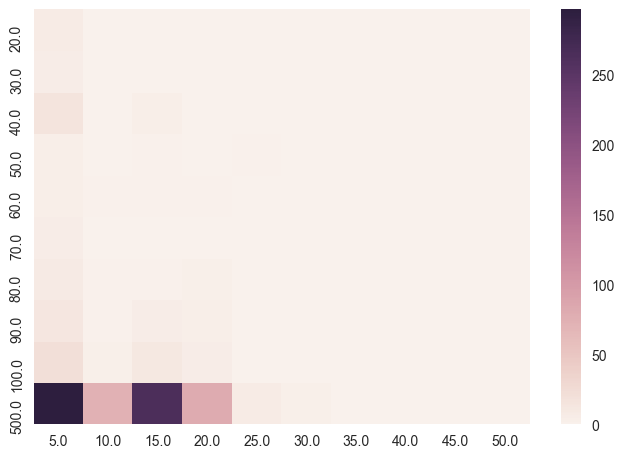

In [602]:
sns.heatmap(data,xticklabels=widths, 
            yticklabels=lengths)

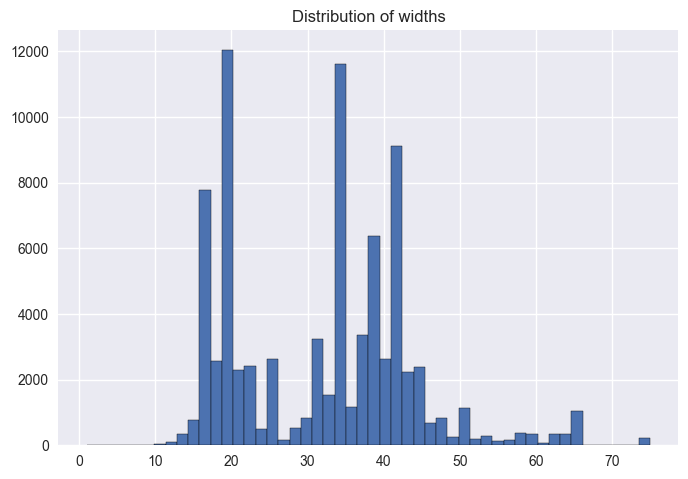

In [291]:
plt.hist(w, bins=50,ec='k');
plt.title('Distribution of widths');

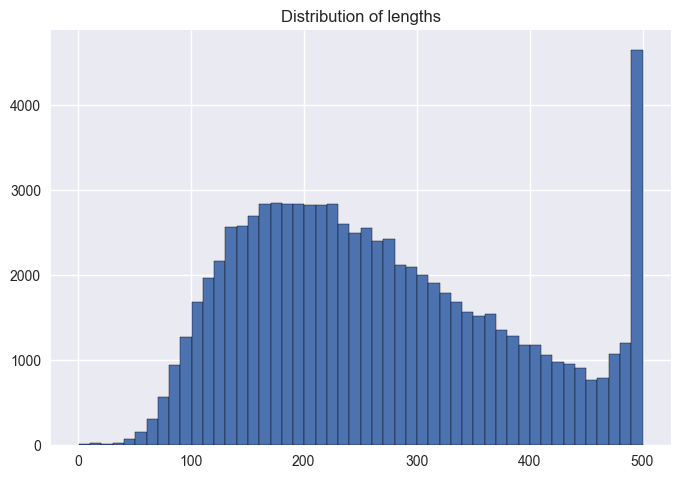

In [292]:
plt.hist(l, bins=50,ec='k');
plt.title('Distribution of lengths');

We notice that there is a bimodal distribution for widths with peaks centred somewhere around 20 and 40 (approximately) and a skewed distribution that peaks at around 200 for lengths.

In [334]:
np.random.randint(0,10,10)

array([6, 8, 6, 8, 9, 6, 1, 5, 9, 9])

In [335]:
w,l,p = map(np.array, [w,l,p])

In [296]:
with open('/Users/user/eecs/Deep_Learning/im2latex/im2latex_formulas.lst','rb') as f:
    eqs = f.readlines()

In [300]:
id_name_pairs = [(id_[:-1].split())[:-1] for id_ in train_ids]

In [301]:
name2id = dict([(name+'.png',int(id_)) for id_, name in id_name_pairs 
                if (name+'.png' in(train_files))])

In [311]:
ids = [name2id[name] for name in train_files]

In [312]:
train_eqs = np.array(eqs)[ids]

In [313]:
from nltk.tokenize import RegexpTokenizer

def tokenizer(sentence):
    tokenizer_ = RegexpTokenizer('\\\\[A-Za-z]+|\\\\\S|\[A-Za-z]+|\d|\S')
    if type(sentence) is not str:
        sentence = sentence.decode()
    return tokenizer_.tokenize(sentence)

# Example
tokenizer("xy")

['x', 'y']

In [314]:
def get_length(eq):
    try:
        return len(tokenizer(eq))
    except:
        return -1

In [315]:
train_eq_lengths = np.array([get_length(eq) for eq in train_eqs])

In [316]:
lengths_exist = np.where(train_eq_lengths > -1)

plt.hist(train_eq_lengths[lengths_exist], ec='k',bins=50);

What is the relationship between width of equation in the image compared to the number of tokens? 

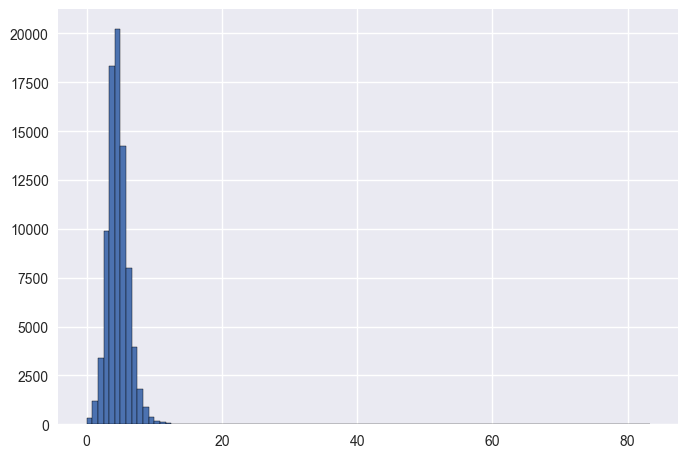

In [323]:
plt.hist(l[lengths_exist]/train_eq_lengths[lengths_exist], ec='k',bins=100);

The distribution is fairly normal and very narrow as one might well expect it to be.

b'\\frac{d^2}{dx^2}h^{\\pm}(\\nu;k;x)\\mp 2ik\\frac{dh^\\pm}{dx}(\\nu;k;x)=U(\\nu;x)h^\\pm(\\nu;k;x)\n'


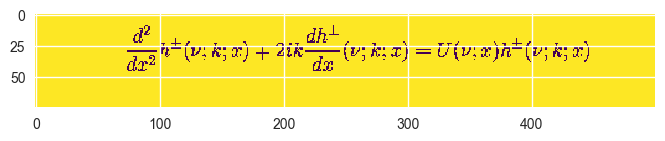

In [324]:
print(train_eqs[lengths_exist][70])
plt.imshow(plt.imread(p[lengths_exist][70]))

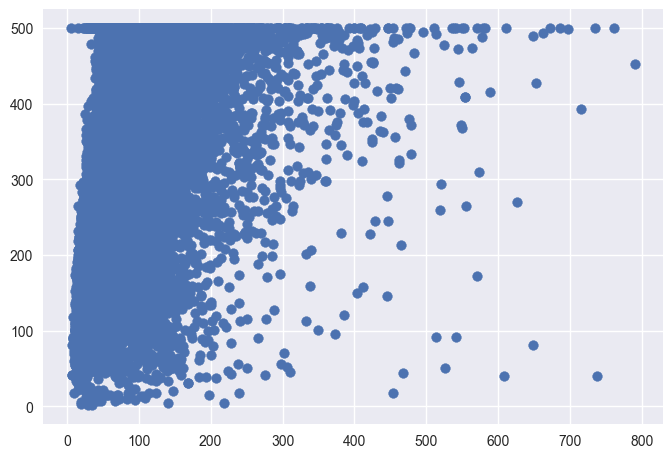

In [356]:
plt.scatter(train_eq_lengths[lengths_exist], l[lengths_exist]);

The pattern is not extremely clear cut but it does seem that longer image widths correspond to more tokens. We want to restrict ourselves to around a maximum of 50 tokens. Let us consider how things look like for these.

In [350]:
inds_max_50 = np.where(train_eq_lengths <= 50)

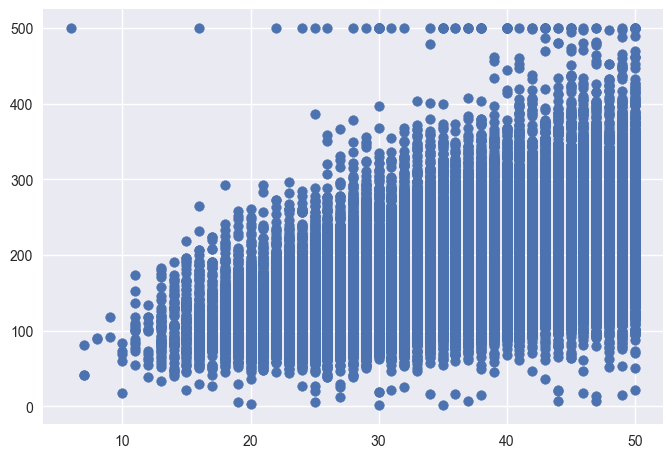

In [354]:
plt.scatter(train_eq_lengths[inds_max_50], l[inds_max_50]);

The plot shows a clear increasing trend of image width with number of tokens. Yet there is rather a wide vertical spread. Let us look at some images with a large number of tokens but small width.

3990 124 45.0 b'{\\sf X}=\\left(\\begin{array}{cc}1 & 0 \\\\0 & -ip\\llap/ \\end{array}\\right),\\label{X}\n'
1317 176 46.0 b'\\label{eOprM-a}e_1 \\cdot e_{j-1} = c^{-1} \\, B_{j-1}(z) \\, e_{j},\n'
6615 98 49.0 b'\\vec{\\phi}=\\frac{\\vec{\\varphi}}{1+\\frac{g^2}{4}{\\vec{\\varphi}}^2},\\label{coordinatetr}\n'
6426 155 47.0 b'\\label{C1avt}\\langle T_{\\mu \\nu} \\rangle = \\frac{1}{2\\kappa^2} k_\\mu k_\\nu \\hat{C}^\\lambda \\hat{C}^*_\\lambda\n'
5255 194 49.0 b'\\label{gbmn}g_{\\mu\\nu}= \\eta _{\\mu\\nu} +\\frac{X_\\mu X_\\nu }{l^2-\\eta _{\\alpha\\beta}X^\\alpha X^\\beta},\n'
4536 136 46.0 b'B_{\\mu }^{\\,\\,\\,ab}=\\omega _{\\mu }^{\\,\\,\\,ab}+K_{\\mu }^{\\,\\,\\,ab},  \\label{6}\n'
7088 186 47.0 b'{\\cal P}^i_1 = -\\frac{\\nu_0}{2} e^{2\\phi} \\delta^{i3}  + B^\\dagger\\sigma^i B\\ .\\label{dpb}\n'
1289 22 50.0 b'm_{\\rm T}^{2} %= {3 g_{p}^{2} \\over{4 G_{\\rm T}}} = 6 m^{2} ~,\\label{e:mv}\n'
4828 196 48.0 b'E = v Q_M\\left(1 + {Q_E^2 \\over2 Q_M^2} + \\cdots \\right) \\label

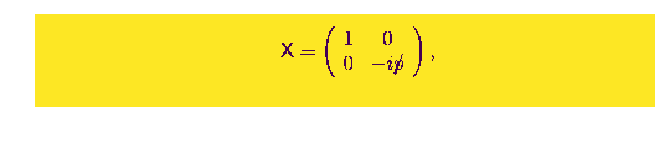

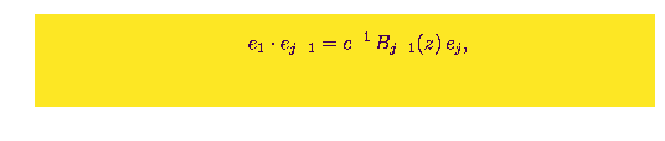

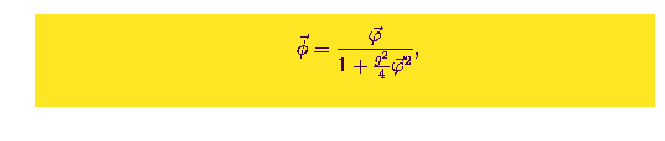

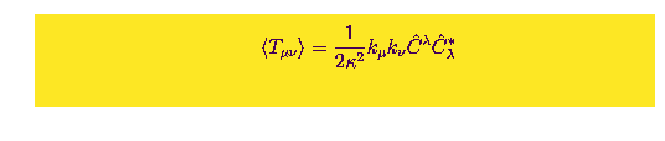

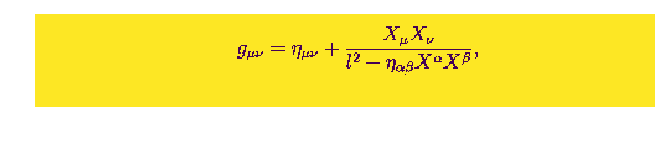

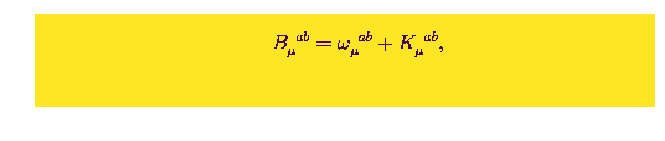

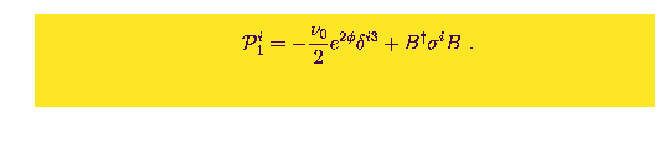

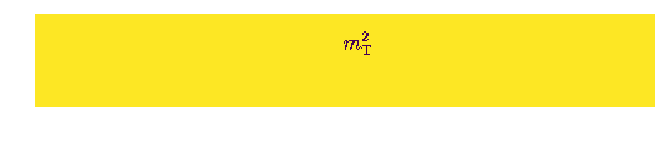

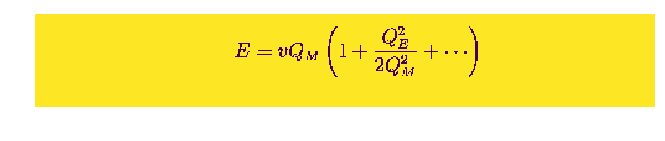

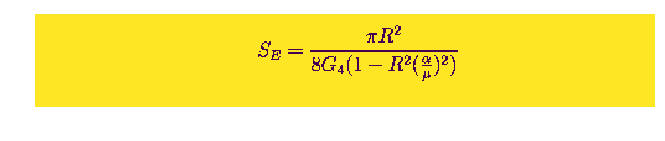

In [387]:
long_ = np.where(train_eq_lengths[inds_max_50] >= 45)
long_narrow = np.where(l[inds_max_50][long_] <=200)[0]
np.random.shuffle(long_narrow)
for ind in long_narrow[:10]:
    print(ind, l[inds_max_50][long_][ind],
          train_eq_lengths[inds_max_50][long_][ind],
          train_eqs[inds_max_50][long_][ind])
    plt.figure()
    plt.imshow(plt.imread(p[inds_max_50][long_][ind]))
    plt.axis('off')

Over half of these contain the 'label' tag - as can be seen below our tokenizer treats each character in the label as a separate token - this is wasteful information for the model since labels do not have any effect on the image (unlike other invisible elements such as subscript and superscript prefixes).

In [392]:
np.mean(['label' in i.decode() for i in train_eqs[inds_max_50][long]])

0.55596091205211728

In [393]:
tokenizer(train_eqs[inds_max_50][long][4828])

['E',
 '=',
 'v',
 'Q',
 '_',
 'M',
 '\\left',
 '(',
 '1',
 '+',
 '{',
 'Q',
 '_',
 'E',
 '^',
 '2',
 '\\over',
 '2',
 'Q',
 '_',
 'M',
 '^',
 '2',
 '}',
 '+',
 '\\cdots',
 '\\right',
 ')',
 '\\label',
 '{',
 'B',
 'P',
 'S',
 'd',
 'y',
 'o',
 'n',
 'E',
 'e',
 'x',
 'p',
 'a',
 'n',
 's',
 'i',
 'o',
 'n',
 '}']

In [454]:
from nltk.tokenize import RegexpTokenizer
import re
def tokenizer_no_label(sentence):
    tokenizer_ = RegexpTokenizer('\\\\[A-Za-z]+|\\\\\S|\[A-Za-z]+|\d|\S')
    if type(sentence) is not str:
        sentence = sentence.decode()
    sentence = re.sub(string=sentence,
                      pattern=r'\\label\{[^\}]+\}',
                      repl='')
    return tokenizer_.tokenize(sentence)

# Example

In [455]:
def get_length_new(eq):
    try:
        return len(tokenizer_no_label(eq))
    except:
        return np.inf

In [456]:
train_eq_lengths_new = np.array([get_length_new(eq) for eq in train_eqs])

In [457]:
lengths_exist_new = np.where(train_eq_lengths_new < np.inf)

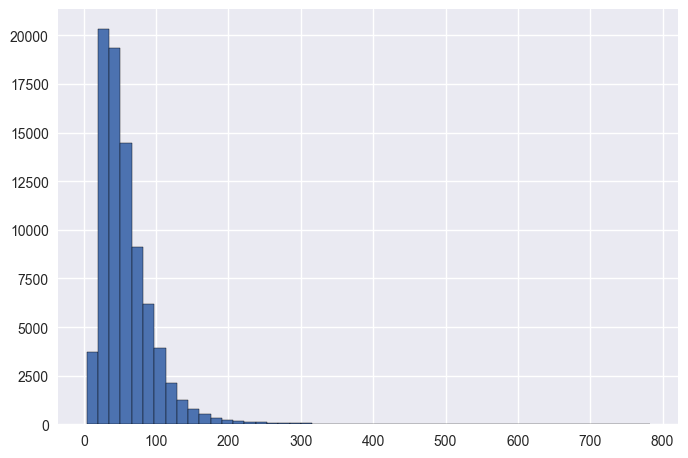

In [458]:
plt.hist(train_eq_lengths_new[lengths_exist_new], bins=50, ec='k');

In [463]:
inds_max_50_new = np.where(train_eq_lengths_new <= 50)

In [464]:
len(inds_max_50_new[0])

43370

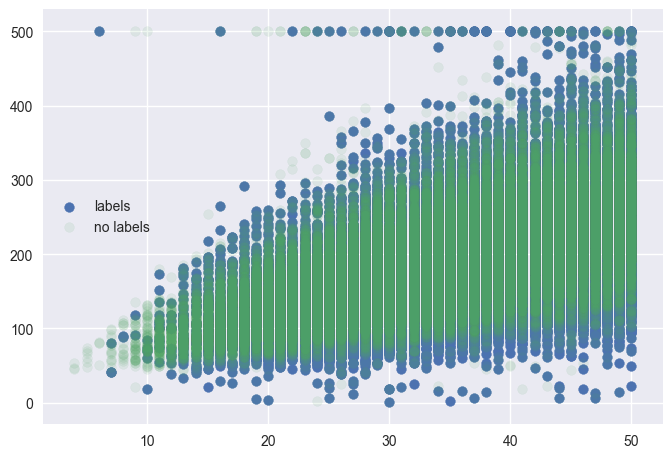

In [479]:
plt.scatter(train_eq_lengths[inds_max_50], l[inds_max_50], label='labels');
plt.scatter(train_eq_lengths_new[inds_max_50_new], l[inds_max_50_new], alpha = 0.1, label = 'no labels')
;
plt.legend();

There seems to be some narrowing - but not all that much - of the vertical spread when you get rid of the `\label` tag.

The remaining equations with narrow images but long token lists, tend to have fractions, several sub or superscripts and matrices. As example of how these can cause token lists to be long - especially if redundant curly brackets are added - consider the equation $C^{\alpha }_{\ \gamma }  C^{\beta }_{\ \gamma }=\frac 1 3 \delta ^{\alpha \beta } C^{\delta }_{\ \gamma }  C^{\delta}_{\ \gamma }$, which has 50 tokens even though it is a simple expression:
```
['C', '^', '{', '\\alpha', '}', '_', '{', '\\', '\\gamma', '}', 'C', '^', '{', '\\beta', '}', '_', '{', '\\', '\\gamma', '}', '=', '\\frac', '1', '3', '\\delta', '^', '{', '\\alpha', '\\beta', '}', 'C', '^', '{', '\\delta', '}', '_', '{', '\\', '\\gamma', '}', 'C', '^', '{', '\\delta', '}', '_', '{', '\\', '\\gamma', '}']```

995 191 50.0 b'M^{\\bar{\\mu} \\bar{\\nu}}(\\lambda)=\\frac{1}{4}~[\\Gamma^{\\bar{\\mu}}(\\lambda),\\Gamma^{\\bar{\\nu}}(\\lambda)],\n'
23 137 51.0 b'\\left\\{\\begin{array}{ll}t=\\frac{n-m}{2} \\\\s=3(n+m)-1\\end{array}\\right. \\label{s2}\n'
3608 179 45.0 b'H_{j,j+1} \\equiv {\\cal P}_{j,j+1} \\left. \\frac{d R(\\theta)}{d\\theta}\\right|_{\\theta =0}\\nonumber\n'
1619 154 48.0 b'\\sigma > \\frac{(0.2\\,\\,{\\rm MeV})^2}{2 (1+\\lambda)}\\,\\frac{\\tilde \\rho^2 }{\\hat \\rho^{3/2}}\\,.\n'
3061 150 45.0 b'\\omega^{ij}=\\left( \\begin{array}{cc} 0 & I_N \\\\ -I_N & 0 \\end{array} \\right) \\,.\n'
3819 166 49.0 b'V_{n_2} \\phi _{\\rho _1} = e^{-i\\frac{n_1n_2}{2N}\\pi}    \\phi _{\\rho _1} V_{n_2}\n'
5714 200 53.0 b'\\label{10.6}w_R(E)\\simeq {1 \\over {\\sigma_R\\sqrt{\\pi} }}e^{-{(E-E_R)^2 \\over \\sigma^2_R}}~~~.\n'
811 154 47.0 b'\\delta \\hat{D} = 4\\partial\\hat{\\Delta}-{\\textstyle\\frac{2}{5}}\\hat{\\vec{\\Sigma}}{}^{T}\\eta\\hat{\\vec{\\cal H}}\\, ,\n'
693 153 50.0 b'C^{\\alph

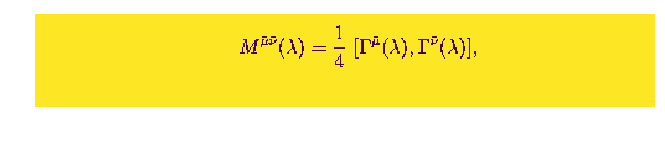

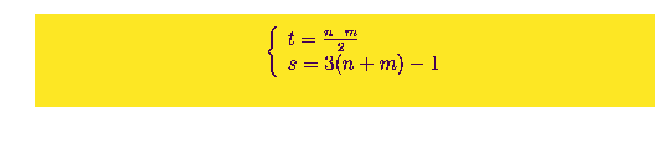

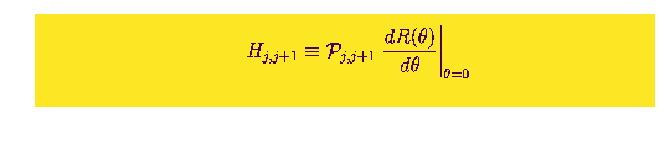

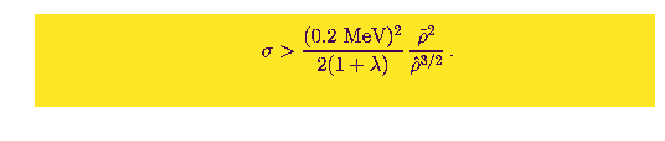

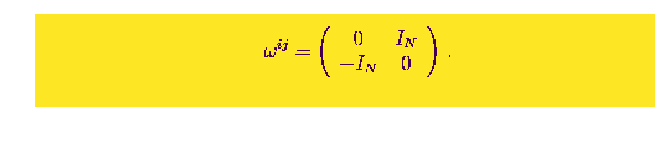

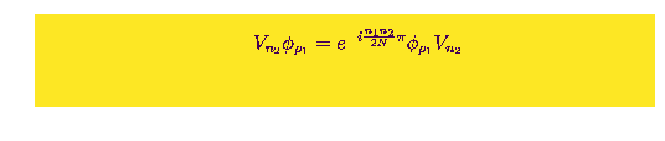

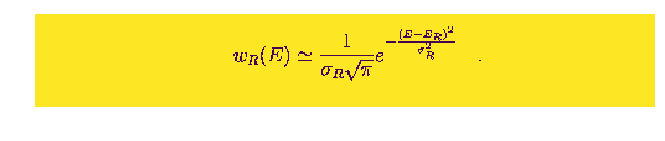

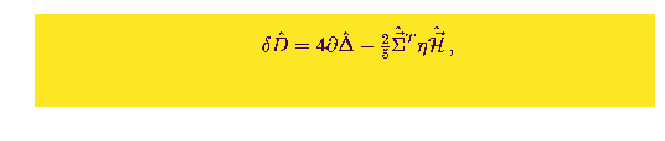

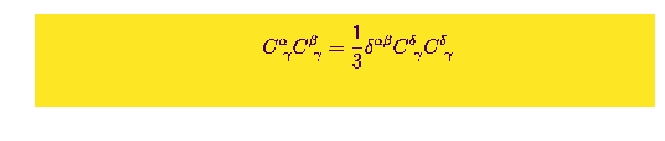

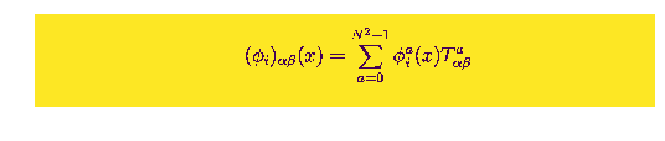

In [467]:
long_ = np.where(train_eq_lengths_new[inds_max_50_new] >= 45)
long_narrow = np.where(l[inds_max_50_new][long_] <=200)[0]
np.random.shuffle(long_narrow)
for ind in long_narrow[:10]:
    print(ind, l[inds_max_50_new][long_][ind],
          train_eq_lengths[inds_max_50_new][long_][ind],
          train_eqs[inds_max_50_new][long_][ind])
    plt.figure()
    plt.imshow(plt.imread(p[inds_max_50_new][long_][ind]))
    plt.axis('off')

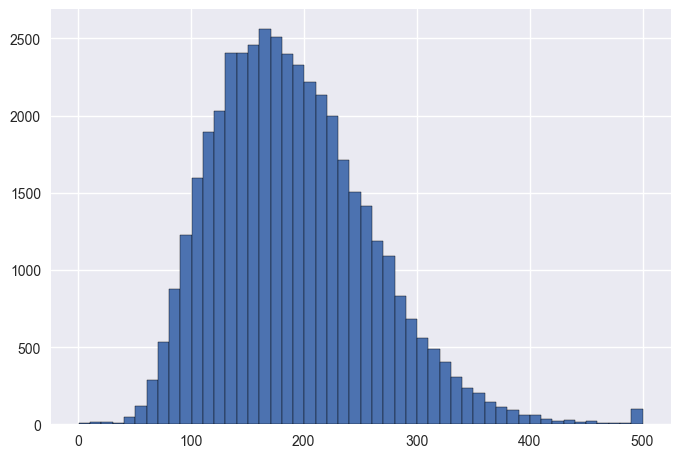

In [498]:
plt.hist(l[inds_max_50_new], ec='k', bins=50);

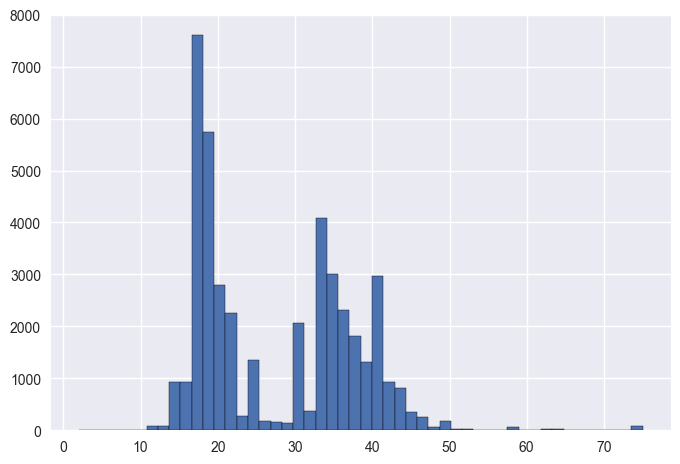

In [500]:
plt.hist(w[inds_max_50_new], ec='k', bins=50);

The distribution for the widths is less skewed now. Also the widths are almost all less than 400 and the lengths almost all under 50. It therefore makes sense to crop all the images after restricting the example to those where the equation length is under 50 tokens. 

Let us see how things are for under 40.

In [506]:
inds_max_40 = np.where(train_eq_lengths_new <= 40)

In [507]:
len(inds_max_40[0])

30952

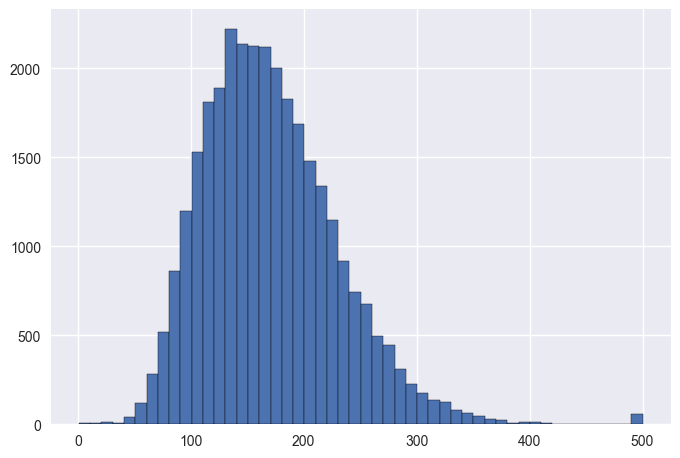

In [508]:
plt.hist(l[inds_max_40], ec='k', bins=50);

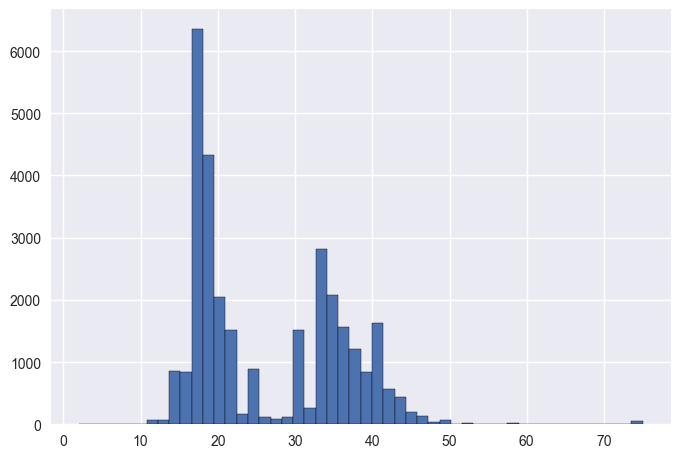

In [509]:
plt.hist(w[inds_max_40], ec='k', bins=50);

There is isn't a significant difference in the distributions for 40 and 50 but we would reduce the number of examples considerably if we use only those with token length below 40 so what we will do is to restrict ourselves to all those images where the width is under 400 and number of tokens under 50.

In [521]:
len(l[inds_max_50_new]),len(np.where(l[inds_max_50_new] <= 400)[0])

(43370, 43072)

We could actually reduce it to those where the width is below 300.

In [522]:
len(l[inds_max_50_new]),len(np.where(l[inds_max_50_new] <= 300)[0])

(43370, 40480)

In [547]:
a,b = np.percentile(l/w,[10,90])

In [548]:
ratio = (l/w)[inds_max_50_new]
len(np.where(((ratio) >= a) & ((ratio) <=b))[0])

33970

A possibility of course is to distort the images so that smaller ones fill the frame instead of having large amounts of empty space. For now we will just stick to things as they are.

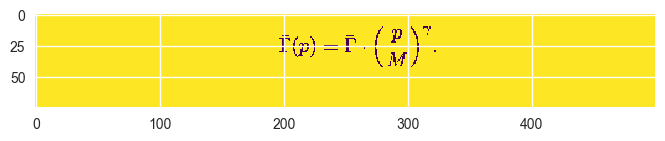

In [565]:
plt.imshow(plt.imread(p[inds_max_50_new][np.where(l[inds_max_50_new] <= 300)][1110]))

In [704]:
path_  = 'eq_images/processed_images_500_75'

In [566]:
len(tokenizer_no_label(
        train_eqs[inds_max_50_new][np.where(l[inds_max_50_new] <= 300)][1110]))

25

In [567]:
train_eqs[inds_max_50_new][np.where(l[inds_max_50_new] <= 300)][1110]

b'\\bar \\Gamma(p) = \\bar \\Gamma \\cdot\\biggl(\\frac{p}{M}\\biggr)^{\\gamma}.\\label{fix}\n'

In [634]:
inds_w_max_300 = np.where(l[inds_max_50_new] <= 300)

In [635]:
inds_l_max_50 = np.where(w[inds_max_50_new][inds_w_max_300] <= 50)

In [638]:
len(inds_l_max_50[0])

40277

In [766]:
train_names = np.array([path.split('/')[-1] for path in 
               p[inds_max_50_new][inds_w_max_300][inds_l_max_50] ])

In [774]:
all_but = np.where(train_names != '3628b3c8cd.png')

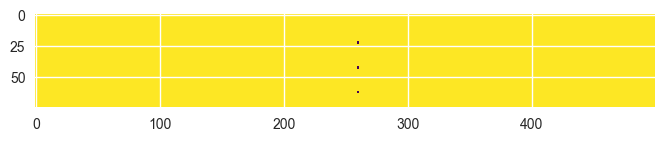

In [777]:
plt.imshow(plt.imread(os.path.join(path_,'3628b3c8cd.png')))

This a virtually empty image.

In [778]:
empty_ind = np.where(train_names == '3628b3c8cd.png')

233
30751
18560
35916
12170
12476
4809
15772
21670
34115


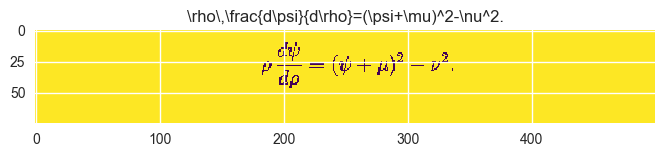

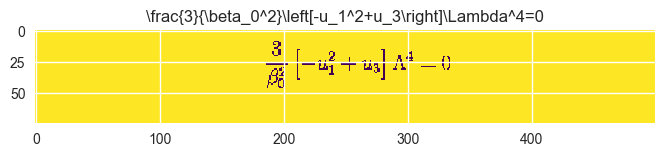

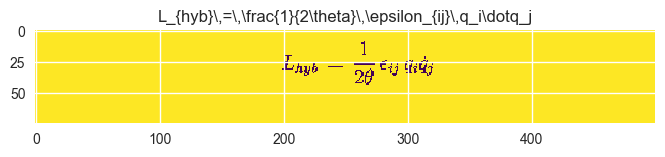

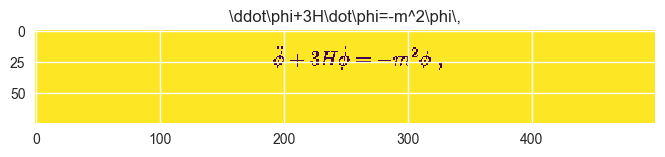

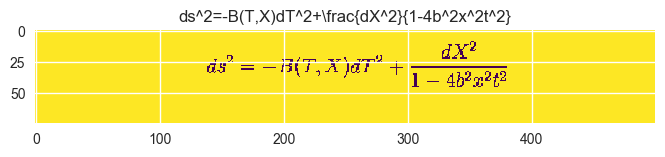

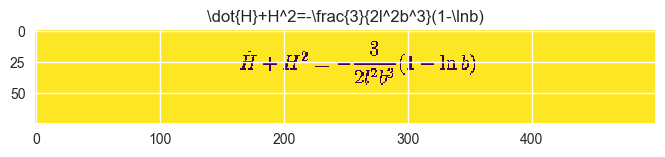

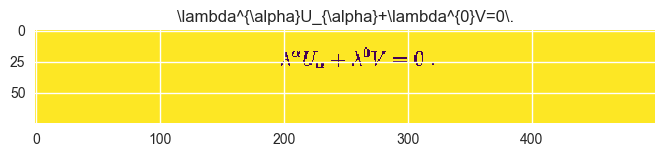

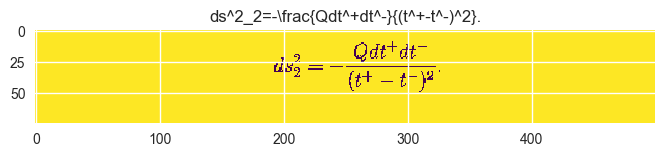

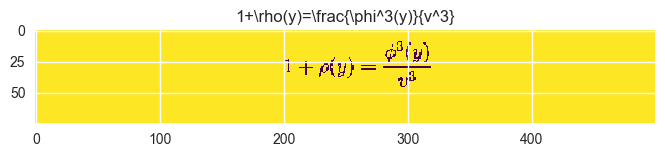

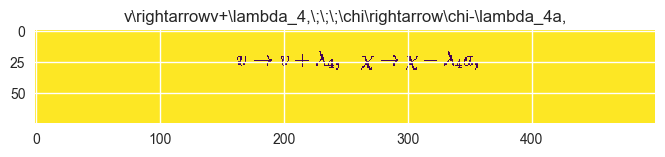

In [804]:
for i in range(10):
    choice = np.random.randint(len(train_names))
    print(choice)
    plt.figure()
    plt.imshow(Image.open(os.path.join(path_, (train_names_[choice]))))
    plt.title(''.join(tokenizer_no_label(train_selected_eqs[choice])))